## Загрузка данных и предобработка

Ранее мы разобрали как мы загружаем и как предобрабатываем данные в блокноте main_linear.ipynb Поэтому не будем останавливаться на этом моменте.
(Ниже в одной ячейке кода собрана вся подготовка данных и подключенные библиотеки)

In [1]:
import pandas as pd 
from matplotlib import pyplot as plt

# Заранее установим несколько констант
RANDOM_STATE = 42

from utils import PreprocessingDataRegInNumber, load_data_reg_task
data = load_data_reg_task()
prepoc = PreprocessingDataRegInNumber(data)

prepoc.fit_transform()
prepoc.save()
data_df = prepoc.get_data()

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data_df.drop("price", axis=1), data_df["price"],
                                                    test_size=0.2, random_state=RANDOM_STATE) 

from utils import ModelsRegressionHistory
history_models = ModelsRegressionHistory()

## Деревья решений

Деревья решений - это методы для решения задач с использованием машинного обучения построенные на теории деревьев. Дерево в нашем случае это некий алгоритм с проверками, который проверит инетересующие его параметры и их значения. После всех проверок он выдаст нам свой *predict*

Особенности этих методов:
* можно визуализировать правила, по которым работает обученная модель;
* не требует масштабирования данных;
* *склоны* к переобучению;

Ниже представлено изображение с примером модели дерева с классификацией.

![Пример дерева](./data/images/trees/example.png)

In [2]:
from sklearn import tree

В библиотеке sklearn у нас есть 2 класса относящихся к древовидным методам. Проведём их сравнение на тмблице ниже

|Характеристика|DecisionTreeRegressor|ExtraTreeRegressor|
|-|-|-|
|Выбор разбиений|Жадный поиск оптимального|Случайный|
|Скорость обучения|Медленее|Быстрее|
|Переобучение|Сильнее|Меньше|
|Структура|Одиночное дерево|Ансамбль|

### ```DecisionTreeRegressor()```

In [3]:
TREE_decision = tree.DecisionTreeRegressor(random_state=RANDOM_STATE)
TREE_decision.fit(X_train, y_train)
y_pred = TREE_decision.predict(X_test)

In [4]:
history_models.add_model(TREE_decision, "tree_model", TREE_decision.get_params(), "Дерево принятия решений", y_true=y_test, y_pred=y_pred)
history_models.to_dataframe()

,Модели,Класс модели,Параметры модели,MAE,MSE,RMSE,R^2,MAPE,MSLE,RMSLE,Заметки
0,DecisionTreeRegressor,tree_model,"{'ccp_alpha': 0.0, 'criterion': 'squared_error...",901.1768,8.819597e+06,2969.7807,0.9829,0.0602,0.0231,0.152,Дерево принятия решений


### ````ExtraTreeRegressor()````

In [5]:
TREE_extra = tree.ExtraTreeRegressor(random_state=RANDOM_STATE)
TREE_extra.fit(X_train, y_train)
y_pred = TREE_extra.predict(X_test)

In [6]:
history_models.add_model(TREE_extra, "tree_model", TREE_extra.get_params(), "Рандомные деревья", y_true=y_test, y_pred=y_pred)
history_models.to_dataframe()

,Модели,Класс модели,Параметры модели,MAE,MSE,RMSE,R^2,MAPE,MSLE,RMSLE,Заметки
0,DecisionTreeRegressor,tree_model,"{'ccp_alpha': 0.0, 'criterion': 'squared_error...",901.1768,8.819597e+06,2969.7807,0.9829,0.0602,0.0231,0.1520,Дерево принятия решений
1,ExtraTreeRegressor,tree_model,"{'ccp_alpha': 0.0, 'criterion': 'squared_error...",1079.9149,1.075329e+07,3279.2215,0.9791,0.0731,0.0302,0.1737,Рандомные деревья


Ниже покажем, что мы можем визуализировать наше дерево с помощью метода ```plot_tree()```
Для этого создадим модель с не большим количеством листьев, чтоб мы могли посмотреть их.

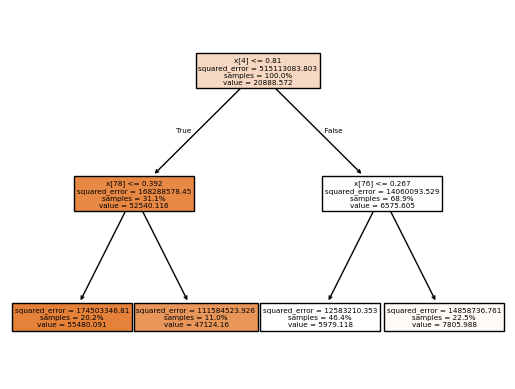

In [7]:
model = tree.ExtraTreeRegressor(max_depth=2,random_state=RANDOM_STATE)
model.fit(X_train, y_train)
tree.plot_tree(model, proportion=True, filled=True)
plt.show()

## Ансамбли

Ансамбли - это мощный инструмент из арсенала ML специалиста и поэтому будет не простительным не уделить ему отдельное внимание.

In [8]:
from sklearn import ensemble

Ансамбли разделяются на 3 вида. Далее мы разберём каждый вид.

#### Бэггинг(паралельное обучени)

Идея бэггинга заключается в обучении множества моделей на разных подвыборках данных и усреднении их предсказаний. Пример такого алгоритма это *Random Forest* 

Давайте сразу рассмотрим реализацию случайного леса на наших данных.

In [9]:
EN_TREE_RandomForestRegressor = ensemble.RandomForestRegressor(random_state=RANDOM_STATE)
EN_TREE_RandomForestRegressor.fit(X_train, y_train)
y_pred = EN_TREE_RandomForestRegressor.predict(X_test)

history_models.add_model(EN_TREE_RandomForestRegressor, "ensemble_bagging", EN_TREE_RandomForestRegressor.get_params(), "Случайный лес", y_true=y_test, y_pred=y_pred)

Так же мы можем использовать линейные модели. Давайте возьмём линейную модель и будем успользовать ```BaggingRegressor()```. Этот класс позволит нам использвать бэггинг с любой базовой моделью(деревья, линейные модели)

In [10]:
from sklearn import linear_model

EN_PLR_standart = ensemble.BaggingRegressor(
    estimator=linear_model.LinearRegression(),
    n_estimators=10,
    bootstrap=True
)
EN_PLR_standart.fit(X_train, y_train)
y_pred = EN_PLR_standart.predict(X_test)

history_models.add_model(EN_PLR_standart, "ensemble_bagging", EN_PLR_standart.get_params(), "Бэггинг + линейная регрессия", y_true=y_test, y_pred=y_pred)

Мы можем брать любую модель для бэггинга, выше представлен пример.

In [11]:
history_models.to_dataframe()

,Модели,Класс модели,Параметры модели,MAE,MSE,RMSE,R^2,MAPE,MSLE,RMSLE,Заметки
0,DecisionTreeRegressor,tree_model,"{'ccp_alpha': 0.0, 'criterion': 'squared_error...",901.1768,8.819597e+06,2969.7807,0.9829,0.0602,0.0231,0.1520,Дерево принятия решений
1,ExtraTreeRegressor,tree_model,"{'ccp_alpha': 0.0, 'criterion': 'squared_error...",1079.9149,1.075329e+07,3279.2215,0.9791,0.0731,0.0302,0.1737,Рандомные деревья
2,RandomForestRegressor,ensemble_bagging,"{'bootstrap': True, 'ccp_alpha': 0.0, 'criteri...",886.5624,5.745909e+06,2397.0625,0.9889,0.0583,0.0152,0.1231,Случайный лес
3,BaggingRegressor,ensemble_bagging,"{'bootstrap': True, 'bootstrap_features': Fals...",4521.8864,4.477694e+07,6691.5574,0.9131,0.4526,NaN,NaN,Бэггинг + линейная регрессия


#### Стекинг(комбинирование предсказаний)

Стекинг позволяет нам комбинировать несколько моделей с помощью единой мета-модели.


---
```
модель_1 -> результат_1

модель_2 -> результат_2

модель_3 -> результат_3
```
---
```
результат_1 - - \

результат_2 - - -> мета_модель -> итоговое_предсказание

результат_3 - - /
```

Мы обучаем модели предсказывать результат и на основе предсказаний обучаем мета-модель предсказывать итоговый результат

Давайте соберём пример такого ансамбля

In [12]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import StackingRegressor, RandomForestRegressor

base_estimators = [
    ('rf', RandomForestRegressor(n_estimators=10, max_features=0.5, random_state=42)),
    ('dt', DecisionTreeRegressor(max_depth=5, random_state=42)),
]

# мета моделью выберем линейную регрессию 
meta_model = LinearRegression()

# создадим стэкинг
stacking_reg = StackingRegressor(
    estimators=base_estimators,
    final_estimator=meta_model,
    cv=3,  # поставим 3 фолда для кросс валидации
)

stacking_reg.fit(X_train, y_train)
y_pred = stacking_reg.predict(X_test)

In [13]:
history_models.add_model(stacking_reg, "ensemble_stacking", stacking_reg.get_params(), "стэкинг", y_true=y_test, y_pred=y_pred)

In [14]:
history_models.to_dataframe()

,Модели,Класс модели,Параметры модели,MAE,MSE,RMSE,R^2,MAPE,MSLE,RMSLE,Заметки
0,DecisionTreeRegressor,tree_model,"{'ccp_alpha': 0.0, 'criterion': 'squared_error...",901.1768,8.819597e+06,2969.7807,0.9829,0.0602,0.0231,0.1520,Дерево принятия решений
1,ExtraTreeRegressor,tree_model,"{'ccp_alpha': 0.0, 'criterion': 'squared_error...",1079.9149,1.075329e+07,3279.2215,0.9791,0.0731,0.0302,0.1737,Рандомные деревья
2,RandomForestRegressor,ensemble_bagging,"{'bootstrap': True, 'ccp_alpha': 0.0, 'criteri...",886.5624,5.745909e+06,2397.0625,0.9889,0.0583,0.0152,0.1231,Случайный лес
3,BaggingRegressor,ensemble_bagging,"{'bootstrap': True, 'bootstrap_features': Fals...",4521.8864,4.477694e+07,6691.5574,0.9131,0.4526,NaN,NaN,Бэггинг + линейная регрессия
4,StackingRegressor,ensemble_stacking,"{'cv': 3, 'estimators': [('rf', RandomForestRe...",1022.7285,6.654267e+06,2579.5866,0.9871,0.0673,0.0169,0.1298,стэкинг


#### Бустинг(последовательное улучшение)

Бустинг - последовательно обучает модели, где каждая следующая модель исправляет ошибки предыдущих, фокусируясь на плохо предсказанных примерах. Итоговое предсказание формируется путем взвешенного объединения всех моделей.

Схема работы бустинга

---

```
Данные -> Модель_1 -> Ошибки_1 ->

Модель_2 -> Ошибки_2 -> 

... 

-> Модель_N -> Итоговое_предсказание
```
---

Из преимуществ этого метода по сравнению с бэггингом и одиночными моделями хочется сразу же отметить высокую точность, так же хорошо работает с несбалансированными данными. А вот минусы - это чувствительность к шуму в данных и требует больше времени на обучение


In [15]:
from sklearn.ensemble import GradientBoostingRegressor

gbr = GradientBoostingRegressor(
    n_estimators=1000,
    learning_rate=0.1,
    max_depth=3, 
    subsample=0.5, 
    random_state=42
)

gbr.fit(X_train, y_train)
y_pred = gbr.predict(X_test)

In [16]:
history_models.add_model(gbr, "ensemble_gradient", gbr.get_params(), "градиентный бустинг", y_true=y_test, y_pred=y_pred)
history_models.to_dataframe()

,Модели,Класс модели,Параметры модели,MAE,MSE,RMSE,R^2,MAPE,MSLE,RMSLE,Заметки
0,DecisionTreeRegressor,tree_model,"{'ccp_alpha': 0.0, 'criterion': 'squared_error...",901.1768,8.819597e+06,2969.7807,0.9829,0.0602,0.0231,0.1520,Дерево принятия решений
1,ExtraTreeRegressor,tree_model,"{'ccp_alpha': 0.0, 'criterion': 'squared_error...",1079.9149,1.075329e+07,3279.2215,0.9791,0.0731,0.0302,0.1737,Рандомные деревья
2,RandomForestRegressor,ensemble_bagging,"{'bootstrap': True, 'ccp_alpha': 0.0, 'criteri...",886.5624,5.745909e+06,2397.0625,0.9889,0.0583,0.0152,0.1231,Случайный лес
3,BaggingRegressor,ensemble_bagging,"{'bootstrap': True, 'bootstrap_features': Fals...",4521.8864,4.477694e+07,6691.5574,0.9131,0.4526,NaN,NaN,Бэггинг + линейная регрессия
4,StackingRegressor,ensemble_stacking,"{'cv': 3, 'estimators': [('rf', RandomForestRe...",1022.7285,6.654267e+06,2579.5866,0.9871,0.0673,0.0169,0.1298,стэкинг
5,GradientBoostingRegressor,ensemble_gradient,"{'alpha': 0.9, 'ccp_alpha': 0.0, 'criterion': ...",2113.0652,1.315968e+07,3627.6275,0.9745,0.1701,NaN,NaN,градиентный бустинг
